In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import sem
from mas import MCTS, BinaryTree

sns.set()

In [2]:
%load_ext autoreload
%autoreload 2

# Assignment 1

---

The function for which we use MC sampling $f(x)=\sin^2(x)$

In [3]:
def f(x):
    return np.sin(x) ** 2

Using MC sampling by first drawing from a random distribution and using that to estimate $E(f(x))$.

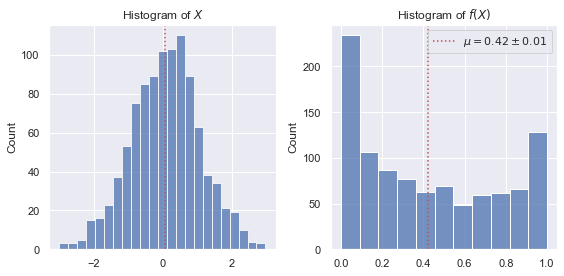

In [4]:
X = np.random.randn(1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

sns.histplot(X, ax=ax1)
ax1.axvline(X.mean(), ls=":", c="r")
ax1.set_title("Histogram of $X$")

U = f(X)
sns.histplot(U, ax=ax2)
m = U.mean()
error = sem(U)
ax2.axvline(m, ls=":", c="r", label=f"$\mu={m:.2f} \pm {error:.2f}$")
ax2.set_title("Histogram of $f(X)$")
ax2.legend()

fig.tight_layout()
fig.savefig("1-1.pdf")

C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Alex Hoorn\miniconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


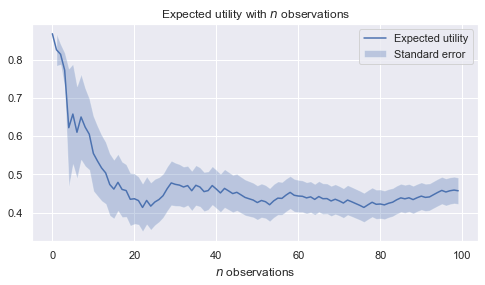

In [5]:
X = np.random.randn(100)
U = f(X)

E = np.array([U[: i + 1].mean() for i in range(len(U))])
error = np.array([sem(U[: i + 1]) for i in range(len(U))])

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(E, label="Expected utility")
ax.fill_between(range(len(E)), E - error, E + error, alpha=0.3, label="Standard error")
ax.legend()
ax.set_title("Expected utility with $n$ observations")
ax.set_xlabel("$n$ observations")

fig.savefig("1-2.pdf")

# Assignment 2

---

Exploring what B and r should be set to.

C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_5424/225013120.py:2: RuntimeWarning: invalid value encountered in true_divide
  return b * np.e ** -(d/r)
C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_5424/225013120.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


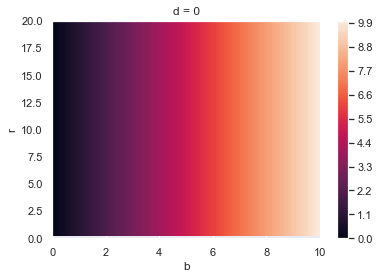

In [6]:
def f(d, b, r):
    return b * np.e ** -(d/r)

b = np.linspace(0,10,100)
r = np.linspace(0,20,100)

d = 0

plt.contourf(b,r,f(d, *np.meshgrid(b, r)), levels=100)
plt.xlabel("b")
plt.ylabel("r")
plt.title(f"{d = }")
plt.colorbar()

C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_5424/225013120.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return b * np.e ** -(d/r)
C:\Users\ALEXHO~1\AppData\Local\Temp/ipykernel_5424/3740169533.py:7: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


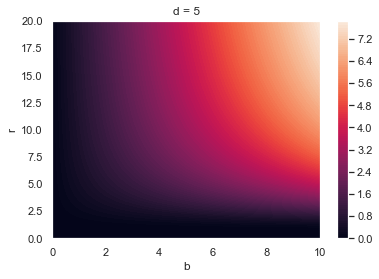

In [7]:
d = 5

plt.contourf(b,r,f(d, *np.meshgrid(b, r)), levels=100)
plt.xlabel("b")
plt.ylabel("r")
plt.title(f"{d = }")
plt.colorbar()

The binary tree class. This is an extremely simple implementation which just generates a random target path and calculates rewards lazily. Can pretty much be of infinite size because of this.

In [8]:
tree = BinaryTree(depth=10000)

path = list(tree.target)
path[0:10] = np.random.choice(tree.choices, 10)
path = tuple(path)
substring = "".join(path[:5]) + "..." + "".join(path[-5:])

print(f"Semi random path {substring} with reward {tree.get_reward(path)}")

Semi random path RLRRR...LRRLR with reward 1.5576015661428098


The Monte Carlo Tree Search algorithm.

In [12]:
tree = BinaryTree(depth=50)

target = tree.target
"".join(target), tree.get_reward(target)

('RLLLLLLLRLRLLRRLLRLLRRRRLRLRLRRRRLLRRRLLRLLLLRRLRR', 2.0)

In [17]:
mcts = MCTS(tree, c=100, iterations=50, max_patience=5, rollouts=50)
mcts.run()

mcts.print_solution()

Found reward=2.00 with path=`RLLLLLLLRLRLLRRLLRLLRRRRLRLRLRRRRLLRRRLLRLLLLRRLRR` in 0.68s and 581 steps


Measuring the impact of c-parameter.

In [113]:
tree = BinaryTree(depth=25)

runtimes = []
steps = []
stops = []
cs = []
rewards = []

for c in np.arange(0, 100, 0.5):
    mcts = MCTS(tree, c=c)
    mcts.run()

    runtimes.append(mcts.runtime)
    steps.append(mcts.search_iterations)
    stops.append(mcts.early_stops)
    cs.append(c)
    rewards.append(mcts.reward)

Showing the impact of the c-parameter.

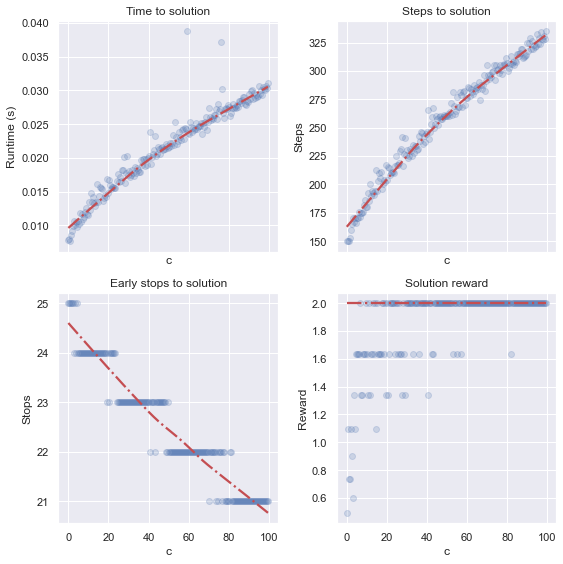

In [114]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8), sharex=True)
reg_kwargs = dict(lowess=True, scatter_kws=dict(alpha=0.2), line_kws=dict(color="r", linestyle="-."))

sns.regplot(x=cs, y=runtimes, ax=ax1, **reg_kwargs)
ax1.set_ylabel("Runtime (s)")
ax1.set_xlabel("c")
ax1.set_title("Time to solution")

sns.regplot(x=cs, y=steps, ax=ax2, **reg_kwargs)
ax2.set_ylabel("Steps")
ax2.set_xlabel("c")
ax2.set_title("Steps to solution")

sns.regplot(x=cs, y=stops, ax=ax3, **reg_kwargs)
ax3.set_ylabel("Stops")
ax3.set_xlabel("c")
ax3.set_title("Early stops to solution")

sns.regplot(x=cs, y=rewards, ax=ax4, **reg_kwargs)
ax4.set_ylabel("Reward")
ax4.set_xlabel("c")
ax4.set_title("Solution reward")

fig.tight_layout()
fig.savefig("2-1.pdf")